In [1]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV,DSP
PythonPlot.svg(true)
include("model.jl")
include("formulas.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

# Trajectories and autocorrelations

In [3]:
d = 2
bz =[1.0,0.0]
init = [0.0, 0.0, 0.0, 0.0]
dt = 0.05
T = 5000
ν0 = 1/log(2)
vz = 0.005 # variance of z

ω0_range = collect(1.:2.:7.0)
η_range = collect(0.1:0.3:1.)
dfs = []

i = 1
for ω0 in ω0_range
    for η in η_range
        bz = -ω0^2
        a = ω0*η
        σ = sqrt(vz*a*ω0^2) # variance of noise in z
        A = [-a 0.0; 0.0 -a]
        Γ = [σ 0.0; 0.0 σ]
        uz = [1.0,0.0]
        bz = [bz, 0.0]
        uθ = zeros(2)
        Cθ = zeros(2,2)
        b̃θ = zeros(2)
        params = (A,bz,b̃θ,uz,uθ,Cθ,Γ,ν0)
        init = [0.0, 0.0, 0.0, 0.0]
        df = make_sim_df(init, params, dt, T)
        df.ω0 .= ω0
        df.η .= η
        df.lineage .= i

        push!(dfs,df)
        i = i+1
    end
end

dfs = vcat(dfs...);

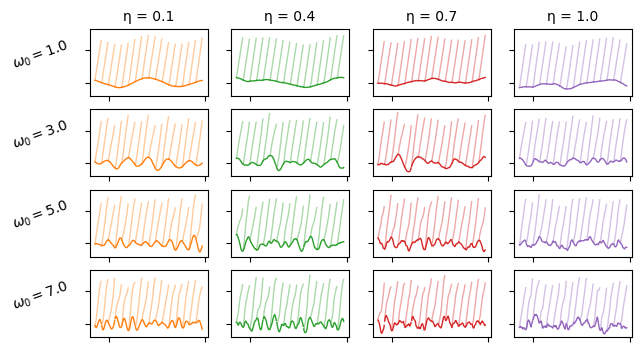

In [9]:
fig,axs = subplots(figsize=(7,4),nrows = length(ω0_range),ncols=length(η_range),sharex=true,sharey=true)
 
for i in 1:length(ω0_range)
    df = dfs[dfs.ω0 .== ω0_range[i],:]
    
    for j in 1:length(η_range)
        ax = axs[i-1,j-1]

        dfj = df[df.η .== η_range[j],:]
        dfj = dfj[(dfj.cell .>= 55) .& (dfj.cell .<= 70),:]
        #ax.plot(dfj.time,dfj.z,"k-",alpha=0.5)
        #ax.axis("off")
        for cell in unique(dfj.cell)
            df_cell = dfj[dfj.cell .== cell,:]

            #ax.plot([df_cell.time[1]],[df_cell.z[1]],"k.",markersize=5.)

            y = df_cell.z .+ log(2)*df_cell.θ
            ax.plot(df_cell.time,df_cell.z,"C$(j)-",lw=1.)
            ax.plot(df_cell.time,y,"C$(j)-",lw=1.,alpha=0.4)
            #ax.plot([df_cell.time[end],df_cell.time[end]],[y[end],y[end]-log(2)],"k--",alpha=0.4,lw=1.)
            # if isphysical(df) == 0
            #     ax.set_facecolor((0.1, 0.1, 0.1, 0.1))
            # end
        end
        #ax.plot([df_cell.time[1] for df_cell in groupby(dfj,:cell)],[df_cell.z[1] for df_cell in groupby(dfj,:cell)],"C$(j).",markersize=5.,lw=0.9)
        

        #ax.set_ylim([-1.5sqrt(vz),1.5sqrt(vz)])
        # turn of y axis tick_params
        ax.tick_params(axis="y",labelleft=false,labelright=false)
        ax.tick_params(axis="x",labelbottom=false,labeltop=false)
    end


end

for j in 1:length(η_range)
    axs[0,j-1].set_title("η = $(η_range[j])",fontsize=10)
end
for j in 1:length(ω0_range)
    axs[j-1,0].set_ylabel("\$\\omega_0 = $(ω0_range[j])\$",fontsize=10,rotation=20,labelpad=30)
    label = axs[j-1, 0].yaxis.get_label()
    label.set_position((10, 0.5))
end
savefig(joinpath(FIG_PATH, "fig2_examples.pdf"), bbox_inches="tight")
fig

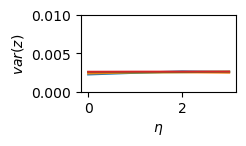

In [5]:
# testing if I've kept the variance the same
fig,ax = subplots(figsize=(2,1))
for ω0 in ω0_range
    df = dfs[dfs.ω0 .== ω0,:]
    ax.plot([var(d.z) for d in groupby(df, :η)],"-",label="ω0 = $ω0")
end
ax.set_ylim([0,0.01])
ax.set_xlabel(L"η")
ax.set_ylabel("\$var(z)\$")
fig

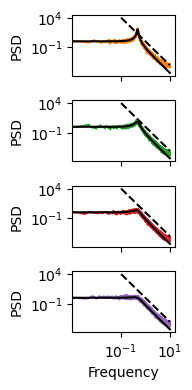

In [15]:
fig,axs = subplots(figsize=(2,4),nrows=length(η_range),sharey=true,sharex=true)
 

df = dfs[dfs.ω0 .== ω0_range[2],:]
ω0 = ω0_range[2]
    
for j in 1:length(η_range)
    η = η_range[j]
    dfj = df[df.η .== η,:]
    z = dfj.z
    fs = 1 / dt  # sampling frequency in Hz
    p = welch_pgram(z, fs=fs)
    freqs = p.freq
    psd = p.power

    ω = 2π .* freqs
    ax = axs[j-1]
    ax.set_ylabel("PSD")
    ax.semilogx(freqs, psd ./psd[2],"C$(j)-")
    psd_theory =[psd_SHO(2π .*f, 0.1, 1 / (η), ω0) for f in freqs]
    ax.loglog(freqs, psd_theory ./psd_theory[2], "k-")
    ax.loglog(freqs[freqs .> 0.1], 1 ./ freqs[freqs .> 0.1] .^4, "k--")
end
axs[length(η_range)-1].set_xlabel("Frequency")

savefig(joinpath(FIG_PATH, "fig2_ac.pdf"), bbox_inches="tight")

tight_layout()
fig

# Eigenvalues for general case

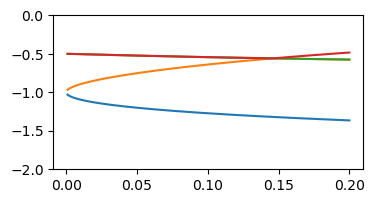

In [43]:
using Polynomials

"""
    smallest_negative_mu(v; atol=1e-10)

Return the smallest (most negative) real root μ of
    μ^4 + 3μ^3 + 2μ^2 - μ + (v - 1) = 0,
if it exists. Returns `nothing` if there is no negative real root.
"""
function smallest_negative_mu(v,a,ω)
    # polynomial coefficients are given from constant term upward
    # assume a, omega, v are defined
    μ = Polynomial([0, 1])  # variable μ
    p = -μ*(μ + a)^3 - (μ + a)^2 * ω^2 + ω^2 * v
    r = roots(p)
    sort([real(x) for x in r])
end

# Examples
vs = collect(0.001:0.001:0.2)
evals = hcat([smallest_negative_mu(v,1,1) for v in vs]...)
fig,ax= subplots(figsize=(4,2))
ax.plot(vs, evals',"-")
ax.set_ylim([-2,0])
fig

In [8]:
import Pkg; Pkg.add("Polynomials")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Polynomials ─ v4.0.21
      Compat entries added for Polynomials
    Updating `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/cell_size/coarse_graining/GrowthCellCycleModel/Project.toml`
⌃ [f27b6e38] + Polynomials v4.0.21
    Updating `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/cell_size/coarse_graining/GrowthCellCycleModel/Manifest.toml`
⌃ [f27b6e38] ↑ Polynomials v4.0.19 ⇒ v4.0.21
        Info Packages marked with ⌃ have new versions available and may be upgradable.
Precompiling project...
  12168.7 ms  ✓ Polynomials
   1412.7 ms  ✓ Polynomials → PolynomialsChainRulesCoreExt
   1478.2 ms  ✓ Polynomials → PolynomialsFFTWExt
   2201.4 ms  ✓ Polynomials → PolynomialsMakieCoreExt
  4 dependencies successfully precompiled in 17 seconds. 358 already precompiled.
  2 dependencies precompiled but different versions are currently loaded. Restart julia to access the

# 